In [114]:
import pandas as pd
import os
import sys
import yaml
import matplotlib.pyplot as plt
import seaborn as sns

In [115]:
# Get the current working directory
current_dir = os.getcwd() 

# Calculate the parent directory (or the project root)
project_root = os.path.dirname(current_dir)

# Append it to sys.path
sys.path.append(project_root)

In [116]:
print("Project root added to sys.path:", project_root)

Project root added to sys.path: c:\Users\Besitzer\OneDrive\Dokumente\CBS_Copenhagen\Semester\WS2025\AdvCV\Final Exam\CV_Test


In [117]:
# Define the paths relative to the project root
relative_head_path = r"data\Head\misclassifications_head.json"
relative_neckHead_path = r"data\NeckHead\misclassifications_neckHead.json"
relative_entireModel_path = r"data\EntireModel\misclassifications_entireModel.json"
relative_classes_path = r"PlayingCardDetection-1\data.yaml"

# Join the project root with the relative paths to get the correct absolute paths
head_path = os.path.join(project_root, relative_head_path)
neckHead_path = os.path.join(project_root, relative_neckHead_path)
entireModel_path = os.path.join(project_root, relative_entireModel_path)
classes_path = os.path.join(project_root, relative_classes_path)

In [118]:
misclassifications_head = pd.read_json(head_path, orient='split')
misclassifications_neckHead = pd.read_json(neckHead_path, orient='split')
misclassifications_entireModel = pd.read_json(entireModel_path, orient='split')

In [119]:
# 1. Read the YAML file
with open(classes_path, 'r') as f:
    yaml_data = yaml.safe_load(f)

# Extract the names and create a mapping
names = yaml_data['names']

# Create the DataFrame with class IDs (0-51 for cards, 52 for background)
df_class_map = pd.DataFrame({
    'class_id': list(range(len(names))) + [52],
    'class_name': names + ['background']
})

In [121]:
# join the misclassification data with the class names for true class
misclassifications_head = misclassifications_head.merge(df_class_map, left_on='True_Class_Index', right_on='class_id', how='left').drop(columns=['class_id'])
# change column name
misclassifications_head = misclassifications_head.rename(columns={'class_name': 'True_ClassName'})

# join the misclassification data with the class names for predicted class
misclassifications_head = misclassifications_head.merge(df_class_map, left_on='Predicted_Class_Index', right_on='class_id', how='left').drop(columns=['class_id'])
# change column name
misclassifications_head = misclassifications_head.rename(columns={'class_name': 'Predicted_ClassName'})

# drop columns
misclassifications_head = misclassifications_head.drop(columns=['True_Class_Index', 'Predicted_Class_Index','Is_Correct', 'True_Class_Name', 'Predicted_Class_Name'])

In [122]:
# join the misclassification data with the class names for true class
misclassifications_neckHead = misclassifications_neckHead.merge(df_class_map, left_on='True_Class_Index', right_on='class_id', how='left').drop(columns=['class_id'])
# change column name
misclassifications_neckHead = misclassifications_neckHead.rename(columns={'class_name': 'True_ClassName'})

# join the misclassification data with the class names for predicted class
misclassifications_neckHead = misclassifications_neckHead.merge(df_class_map, left_on='Predicted_Class_Index', right_on='class_id', how='left').drop(columns=['class_id'])
# change column name
misclassifications_neckHead = misclassifications_neckHead.rename(columns={'class_name': 'Predicted_ClassName'})

# drop columns
misclassifications_neckHead = misclassifications_neckHead.drop(columns=['True_Class_Index', 'Predicted_Class_Index','Is_Correct', 'True_Class_Name', 'Predicted_Class_Name'])

In [123]:
# join the misclassification data with the class names for true class
misclassifications_entireModel = misclassifications_entireModel.merge(df_class_map, left_on='True_Class_Index', right_on='class_id', how='left').drop(columns=['class_id'])
# change column name
misclassifications_entireModel = misclassifications_entireModel.rename(columns={'class_name': 'True_ClassName'})

# join the misclassification data with the class names for predicted class
misclassifications_entireModel = misclassifications_entireModel.merge(df_class_map, left_on='Predicted_Class_Index', right_on='class_id', how='left').drop(columns=['class_id'])
# change column name
misclassifications_entireModel = misclassifications_entireModel.rename(columns={'class_name': 'Predicted_ClassName'})

# drop columns
misclassifications_entireModel = misclassifications_entireModel.drop(columns=['True_Class_Index', 'Predicted_Class_Index','Is_Correct', 'True_Class_Name', 'Predicted_Class_Name'])

In [133]:
# count background misclassifications for true and predicted classes
background_true_count = misclassifications_head[misclassifications_head['True_ClassName'] == 'background']['Count'].sum()
background_predicted_count = misclassifications_head[misclassifications_head['Predicted_ClassName'] == 'background']['Count'].sum() 
print(f"Background as TRUE class misclassifications (Head Model): {background_true_count}")
print(f"Background as PREDICTED class misclassifications (Head Model): {background_predicted_count}")

Background as TRUE class misclassifications (Head Model): 416
Background as PREDICTED class misclassifications (Head Model): 230


Background as TRUE: The model predicted a card where no card was present.

Background as PREDICTED: The model missed a card where one should have been detected.

In [124]:
methods = {
    'Head Model': misclassifications_head,
    'NeckHead Model': misclassifications_neckHead,
    'Entire Model': misclassifications_entireModel
}

In [137]:
def get_error_data(df):
    """Returns the total error count and the top confusion pattern for the worst class."""
    
    # 1. Calculate Total Misclassifications
    df_errors = df[df['Error_Type'] == 'Misclassification']
    total_errors = df_errors['Count'].sum()
    
    # 2. Identify the Worst Struggling Class
    struggling_true_classes = df_errors.groupby('True_ClassName')['Count'].sum().sort_values(ascending=False)
    
    if struggling_true_classes.empty:
        return total_errors, None

    worst_class_name = struggling_true_classes.index[0] 
    
    # 3. Get the Confusion Pattern for the Worst Class
    worst_class_df = df_errors[df_errors['True_ClassName'] == worst_class_name]
    confusion_pattern = worst_class_df.groupby('Predicted_ClassName')['Count'].sum().sort_values(ascending=False).head(7)
    confusion_pattern.name = worst_class_name # Rename series to the class name for clarity
    
    return total_errors, confusion_pattern

C:\Users\Besitzer\AppData\Local\Temp\ipykernel_12752\1572695157.py:26: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x='Model', y='Total Errors', data=df_total_errors, palette='viridis')


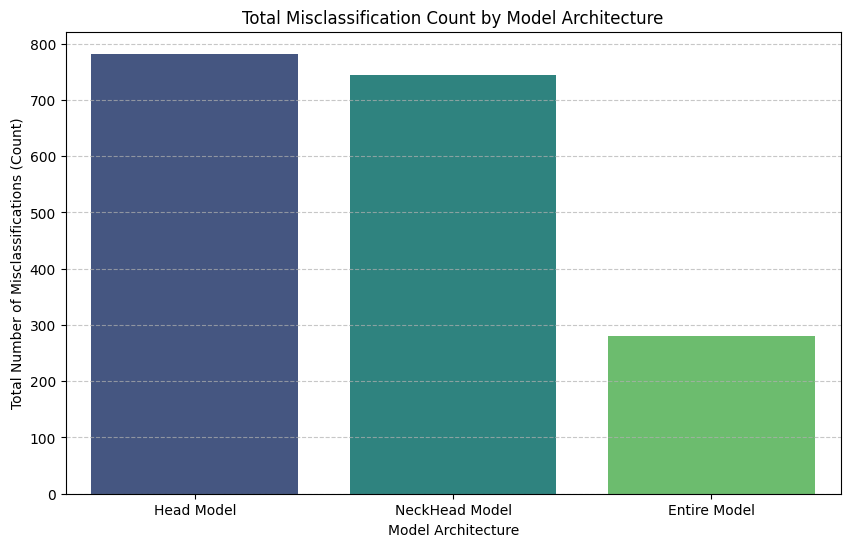

In [138]:
# --- Main Plotting Script ---

# 1. Pre-process and collect data for plotting
total_errors = {}
confusion_data = {} # Will hold the top 5 confusion patterns for the worst class of each model

for name, df in methods.items():
    errors, confusion_pattern = get_error_data(df)
    total_errors[name] = errors
    if confusion_pattern is not None:
        confusion_data[name] = confusion_pattern

# Convert collected data into DataFrames for easy plotting
df_total_errors = pd.Series(total_errors).sort_values(ascending=False).reset_index()
df_total_errors.columns = ['Model', 'Total Errors']

# Combine all confusion patterns into a single DataFrame for the stacked plot
if confusion_data:
    df_confusion_combined = pd.DataFrame(confusion_data).fillna(0)
    # The index will be the Predicted_ClassName
    df_confusion_combined.index.name = 'Predicted_ClassName'
    df_confusion_combined = df_confusion_combined.reset_index()
    
# --- Plot 1: Total Misclassifications by Model ---
plt.figure(figsize=(10, 6))
sns.barplot(x='Model', y='Total Errors', data=df_total_errors, palette='viridis')
plt.title('Total Misclassification Count by Model Architecture')
plt.xlabel('Model Architecture')
plt.ylabel('Total Number of Misclassifications (Count)')
plt.xticks(rotation=0)
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.show()

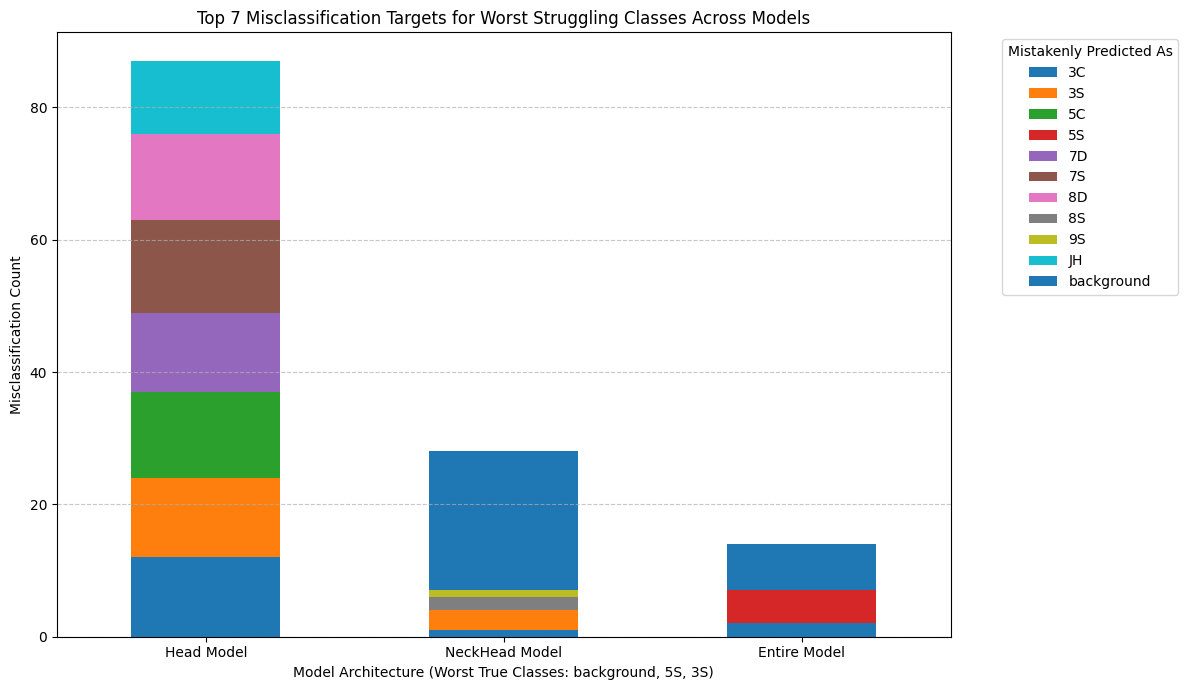

In [139]:
# --- Plot 2: Top Confusion Patterns for the Worst Struggling Class ---
if confusion_data:
    # Set the Predicted_ClassName as the index
    plot_df = df_confusion_combined.set_index('Predicted_ClassName')
    
    # Check if there's any data remaining after filtering
    if not plot_df.empty:
        plot_df.T.plot(kind='bar', stacked=True, figsize=(12, 7))
        
        # Get the names of the worst classes for the title
        worst_classes = [s.name for s in confusion_data.values()]
        
        plt.title(f'Top 7 Misclassification Targets for Worst Struggling Classes Across Models')
        plt.xlabel(f'Model Architecture (Worst True Classes: {", ".join(worst_classes)})')
        plt.ylabel('Misclassification Count')
        plt.xticks(rotation=0)
        plt.legend(title='Mistakenly Predicted As', bbox_to_anchor=(1.05, 1), loc='upper left')
        plt.grid(axis='y', linestyle='--', alpha=0.7)
        plt.tight_layout()
        plt.show()
    else:
        print("\nCould not generate the Confusion Plot as the combined confusion data is empty.")
else:
    print("\nCould not generate the Confusion Plot as no confusion data was returned.")

- Background means model has missed a card where should have been one
- Neck + Head & Entire are pretty confident --> manly missing cards not predicting falsly
- Head only also missclassfies a lot of cards

In [140]:
# most misclassified combinations
for name, df in methods.items():
    print(f"\nMost Misclassified Combinations for {name}:")
    misclassified_combinations = df[df['Error_Type'] == 'Misclassification']
    top_combinations = misclassified_combinations.sort_values(by='Count', ascending=False).head(10)
    print(top_combinations[['True_ClassName', 'Predicted_ClassName', 'Count']])


Most Misclassified Combinations for Head Model:
  True_ClassName Predicted_ClassName  Count
0     background                  7S     14
1             QD          background     14
2     background                  5C     13
3     background                  8D     13
4     background                  7D     12
5     background                  3C     12
6     background                  3S     12
7             AS          background     11
8     background                  JH     11
9     background                  5D     10

Most Misclassified Combinations for NeckHead Model:
   True_ClassName Predicted_ClassName  Count
0              5S          background     21
1              AD          background     20
2              2C          background     18
3              AS          background     18
5              6H          background     15
7              5C          background     14
8              3C          background     14
9              AC          background     14
10       

In [145]:
for name, df in methods.items():
    print(f"\n{'='*50}")
    print(f"Top 10 Card-to-Card Misclassifications for {name}:")
    print(f"{'='*50}")

    # 1. Filter for all misclassifications
    misclassified_combinations = df[df['Error_Type'] == 'Misclassification']
    
    # 2. FILTER OUT Background (Index 52) from TRUE Class
    # (Removes False Positives: Background -> Card)
    df_filtered = misclassified_combinations[
        misclassified_combinations['True_ClassName'] != 'background'
    ]
    
    # 3. FILTER OUT Background (Index 52) from PREDICTED Class
    # (Removes False Negatives: Card -> Background)
    df_filtered = df_filtered[
        df_filtered['Predicted_ClassName'] != 'background'
    ]

    # 4. Sort and display the top 10 remaining pure classification errors
    top_combinations = df_filtered.sort_values(by='Count', ascending=False).head(10)
    
    print(top_combinations[['True_ClassName', 'Predicted_ClassName', 'Count']])


Top 10 Card-to-Card Misclassifications for Head Model:
    True_ClassName Predicted_ClassName  Count
83             10S                 10C      4
84              AD                  4D      4
87              2C                  AC      3
88              2S                  3S      3
92              6C                  8C      3
94              JS                  QS      3
96              KH                  QD      3
99              KS                  QS      3
100             8S                  9S      3
102             3C                  8S      2

Top 10 Card-to-Card Misclassifications for NeckHead Model:
   True_ClassName Predicted_ClassName  Count
42             3S                  3C      8
68             AC                  AS      6
74             KD                  KH      5
76             KH                  KD      5
86             6S                  9S      5
88             8C                  5C      5
90             6H                  5H      4
91             3D 